In [3]:
!pip install snowflake-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.4 MB/s eta 0:00:00


In [14]:
from google.colab import userdata
import snowflake.connector
def return_snowflake_conn():
    user_id = userdata.get('User')
    password = userdata.get('password')
    account = userdata.get('account')

    conn = snowflake.connector.connect(
        user=user_id,
        password=password,
        account=account,
    )
    return conn.cursor()

conn=return_snowflake_conn()
print(conn)

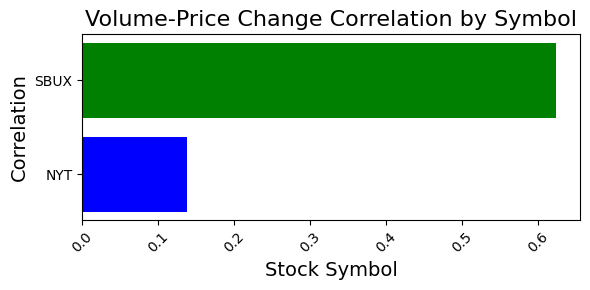

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import snowflake.connector

def plot_corr(con):
    try:
        # Execute the query
        query = """
        WITH price_changes AS (
            SELECT
                DATE,
                CLOSE - LAG(CLOSE, 1) OVER (ORDER BY SYMBOL,DATE) AS PRICE_CHANGE,
                VOLUME, SYMBOL
            FROM
                DEV.STOCK.STOCK_PRICE_ANALYSIS
            WHERE
                VOLUME IS NOT NULL
        )
        SELECT
            ROUND(CORR(VOLUME, PRICE_CHANGE),3) AS VOLUME_PRICE_CORRELATION,
            SYMBOL
        FROM price_changes
        GROUP BY SYMBOL;
        """

        # Execute the query using the SnowflakeCursor object directly
        con.execute(query)

        # Fetch all results into a list of tuples
        data = con.fetchall()

        # Convert the data into a Pandas DataFrame
        df = pd.DataFrame(data, columns=[col[0] for col in con.description])

        # Plot the graph
        plt.figure(figsize=(6, 3))
        colors = ['blue', 'green']  # Define a list of colors
        plt.barh(df['SYMBOL'], df['VOLUME_PRICE_CORRELATION'], color=colors[:len(df)])

        # Adding title and labels
        plt.title('Volume-Price Change Correlation by Symbol', fontsize=16)
        plt.xlabel('Stock Symbol', fontsize=14)
        plt.ylabel('Correlation', fontsize=14)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(e)
        raise e

# Example usage of the function (you need to have the 'con' Snowflake connection object)
plot_corr(conn)

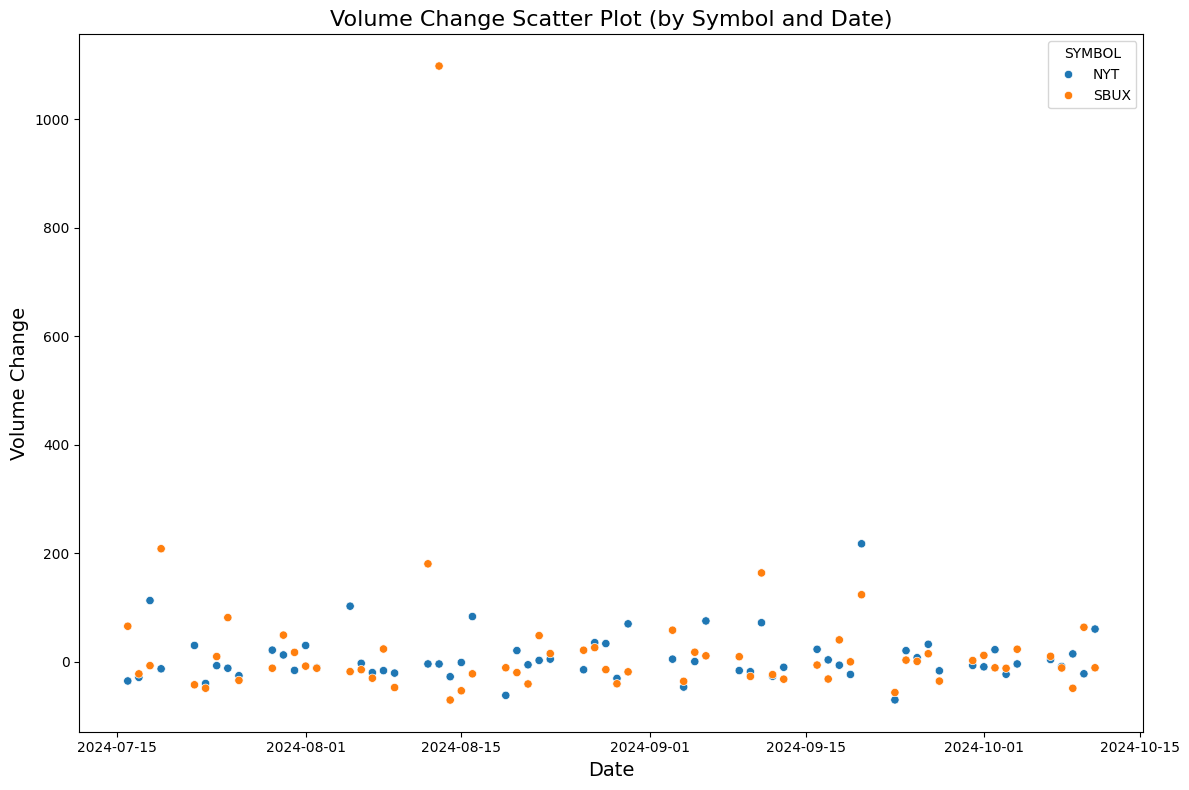

In [32]:
import seaborn as sns
def plot_vol(con):
    try:
        # Execute the query
        query1 = """
            SELECT DATE, SYMBOL, VOLUME_CHANGE_PCT FROM
            DEV.STOCK.STOCK_VOLUMN_POINTS;
        """
        # Use pandas to read the query results directly into a DataFrame
        df = pd.DataFrame(con.execute(query1).fetch_pandas_all())

        # Create the scatter plot using seaborn
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='DATE', y='VOLUME_CHANGE_PCT', hue='SYMBOL', data=df)

        # Adding title and labels
        plt.title('Volume Change Scatter Plot (by Symbol and Date)', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Volume Change', fontsize=14)  # Updated y-axis label for clarity

        # Show the plot
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(e)
        raise e


plot_vol(conn)